# AIML231 Assignment 3
> Shemaiah Rangitaawa `300601546`

This assignment focuses on the design and implementation of a multi-layer perceptron neural network and the use of several machine learning techniques.

## Part One | Linear Regression

In [25]:
import seaborn as sns
from sklearn.model_selection import train_test_split

df = sns.load_dataset('mpg')
X = df.drop('mpg', axis=1)
y = df['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=231)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
219,25.5,4,122.0,96.0,2300,15.5,77,usa,plymouth arrow gs
157,15.0,8,350.0,145.0,4440,14.0,75,usa,chevrolet bel air
242,21.5,4,121.0,110.0,2600,12.8,77,europe,bmw 320i
287,16.5,8,351.0,138.0,3955,13.2,79,usa,mercury grand marquis
230,15.5,8,350.0,170.0,4165,11.4,77,usa,chevrolet monte carlo landau
...,...,...,...,...,...,...,...,...,...
198,33.0,4,91.0,53.0,1795,17.4,76,japan,honda civic
267,27.5,4,134.0,95.0,2560,14.2,78,japan,toyota corona
148,26.0,4,116.0,75.0,2246,14.0,74,europe,fiat 124 tc
176,19.0,6,232.0,90.0,3211,17.0,75,usa,amc pacer


### EDA
> Data stats, scatter plots, histograms, and correlation matrices

In [26]:
def stats(df, exclude_feature=None):
    # If exclude_feature is provided, drop it from the DataFrame
    if exclude_feature and exclude_feature in df.columns:
        df = df.drop(exclude_feature, axis=1)
    
    # Number of instances and features
    num_instances = df.shape[0]
    num_features = df.shape[1]
    print(f"Total number of instances: {num_instances}")
    print(f"Number of features: {num_features}")
    
    # Distinguishing between categorical and numerical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    print(f"Number of categorical features: {len(categorical_features)}")
    print(f"Number of numerical features: {len(numerical_features)}")

stats(df, exclude_feature='mpg')

Total number of instances: 398
Number of features: 8
Number of categorical features: 2
Number of numerical features: 6


> Scatter plots reveal relationships between the variables.

c:\Users\xdxei\anaconda3\envs\AIML231\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\xdxei\anaconda3\envs\AIML231\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\xdxei\anaconda3\envs\AIML231\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\xdxei\anaconda3\envs\AIML231\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with 

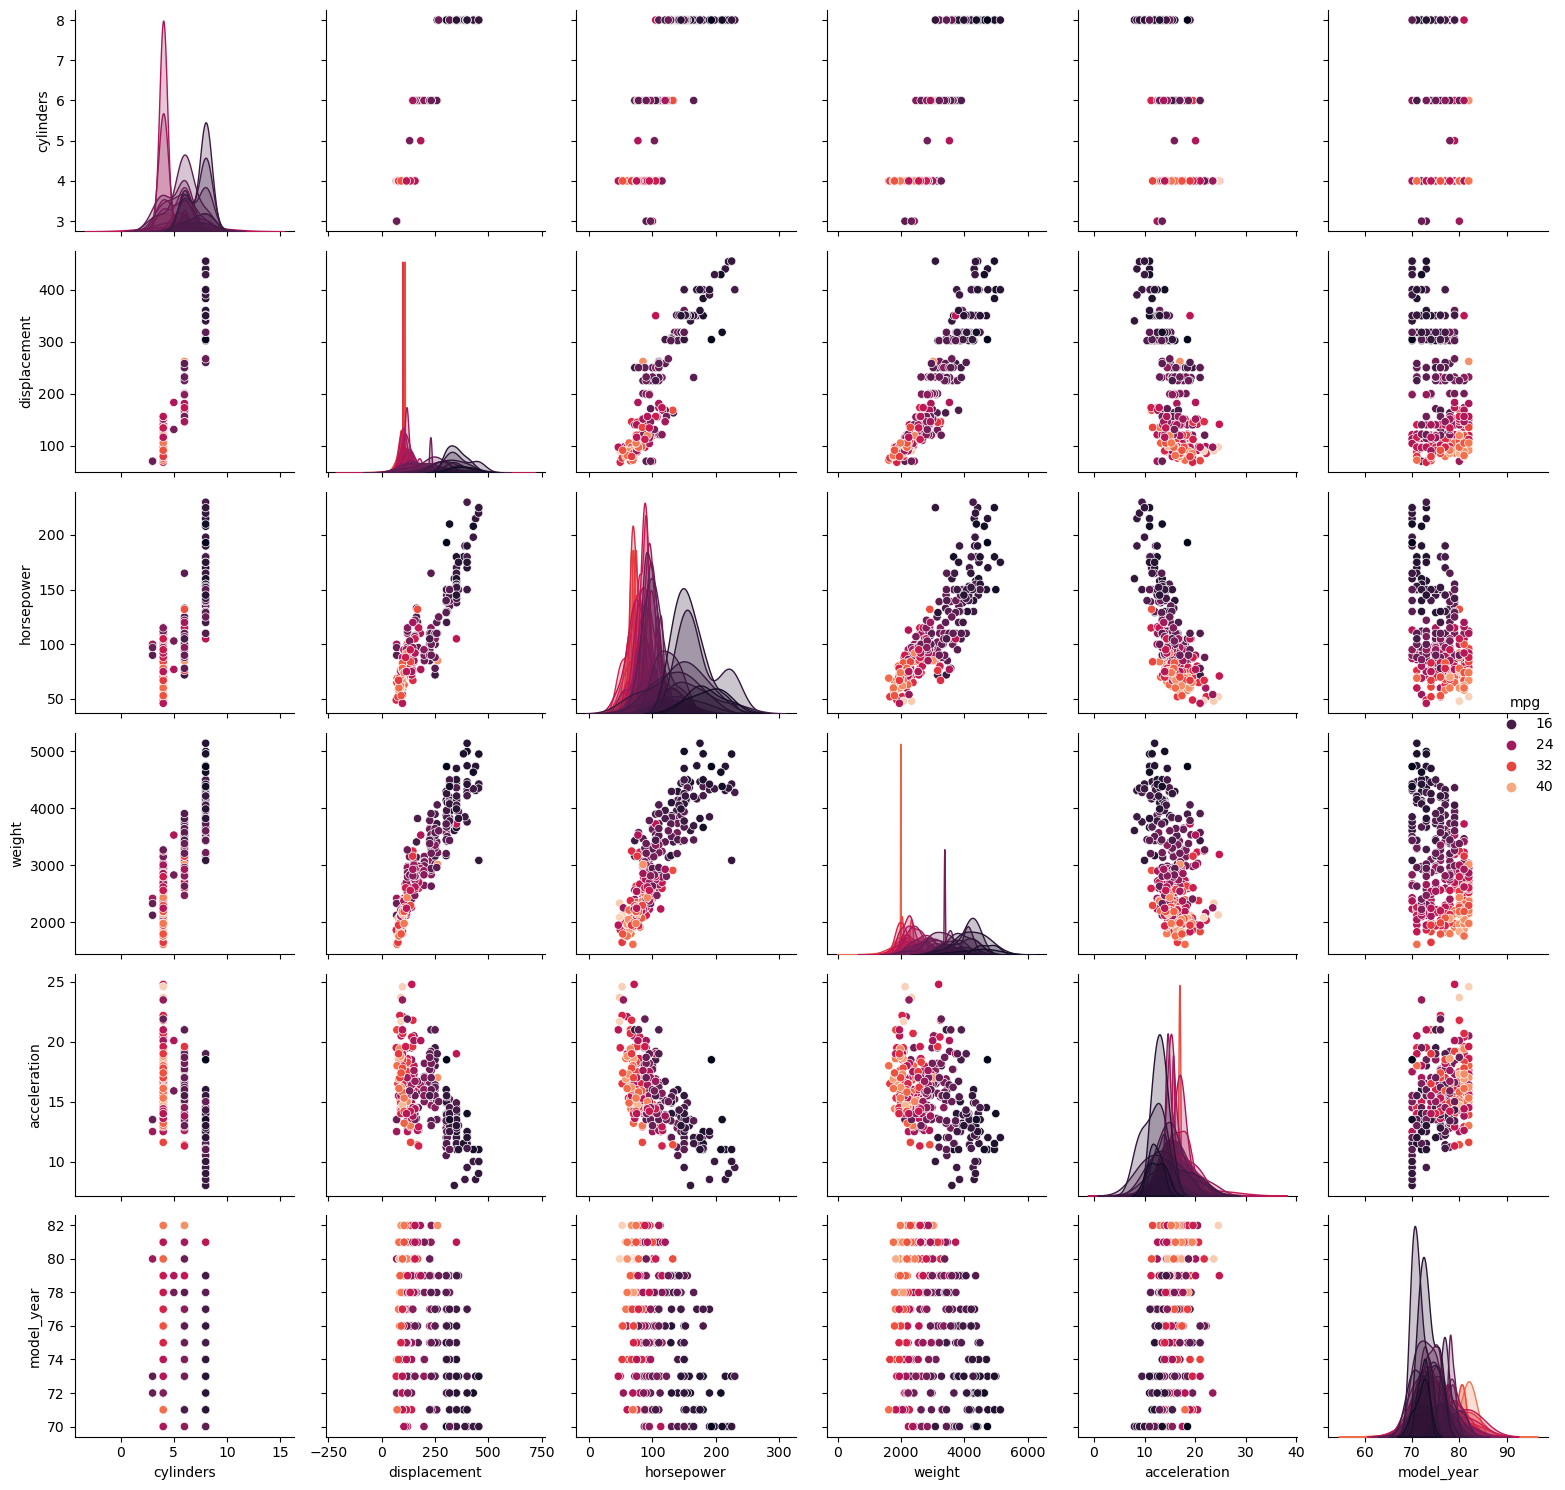

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(train, diag_kind='kde', hue='mpg', palette="rocket")
plt.tight_layout()
plt.show()

> The histograms reveal the distribution of each feature.

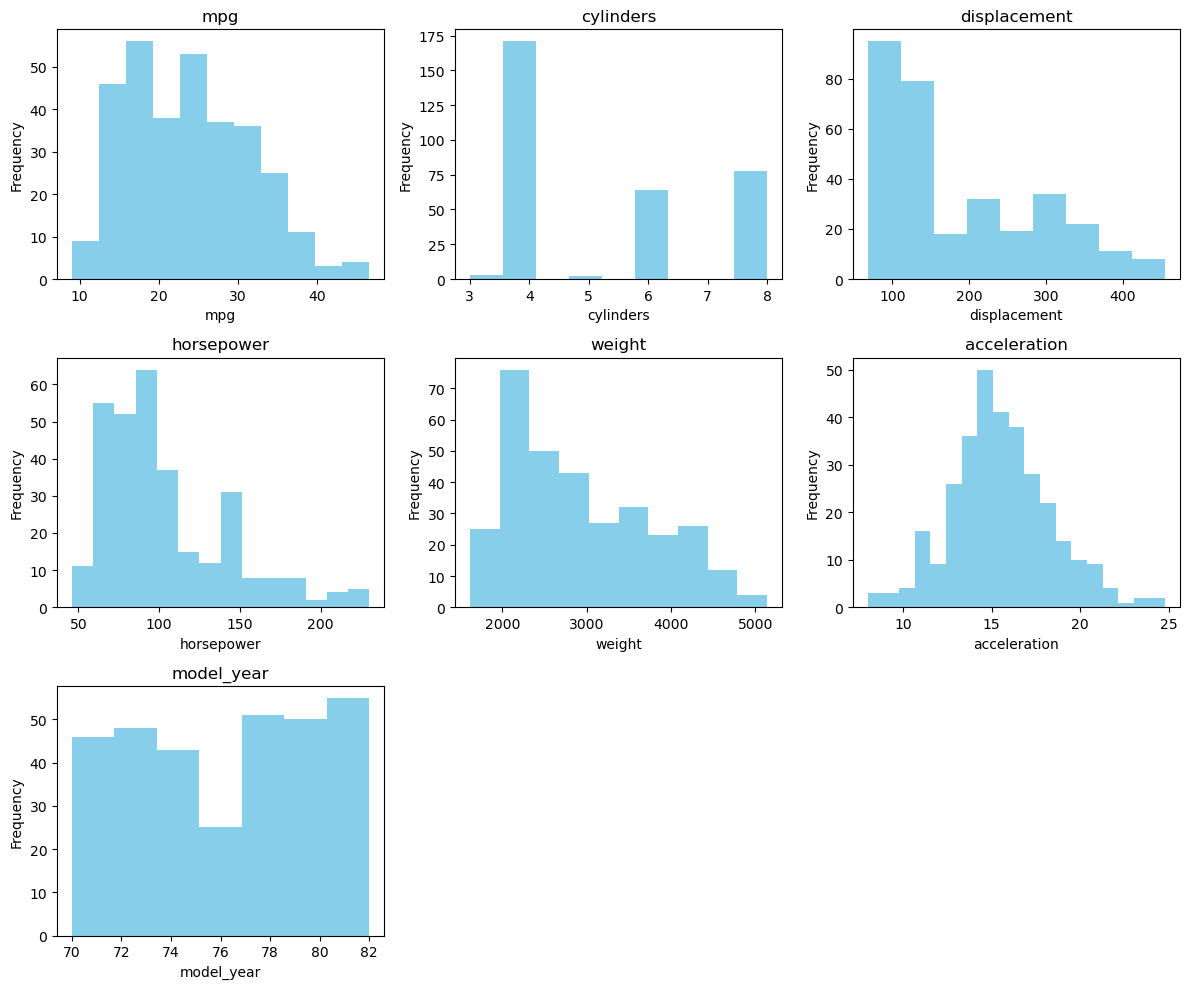

In [3]:
plt.style.use('seaborn-v0_8-muted')
axarr = train.hist(bins='fd', figsize=(12, 10), color='skyblue', grid=False) 
n_cols = len(train.columns)
axes = axarr.flatten()

for i, ax in enumerate(axes):
    ax.set_ylabel('Frequency')
    if i >= len(axes) - n_cols:
        ax.set_xlabel(ax.get_title())

plt.tight_layout()
plt.show()

### Preprocessing
> Median Imputation was used to fill in the missing values in the dataset.

In [4]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [5]:
df['horsepower'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 398 entries, 0 to 397
Series name: horsepower
Non-Null Count  Dtype  
--------------  -----  
392 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


In [6]:
import pandas as pd
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

# Apply the imputer to horsepower
train['horsepower'] = imputer.fit_transform(train[['horsepower']])
test['horsepower'] = imputer.fit_transform(test[['horsepower']])

# Check if any missing values remain
train['horsepower'].isnull().sum(), test['horsepower'].isnull().sum()

(0, 0)

In [28]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess(train_set, test_set):
    ordinal_enc = OrdinalEncoder()
    onehot_enc = OneHotEncoder(drop='if_binary')
    target_enc = TargetEncoder()

    preprocessor = ColumnTransformer(
        transformers=[
            ('ordinal', ordinal_enc, ['cylinders']),
            ('onehot', onehot_enc, ['model_year', 'origin']),
            ('target', target_enc, ['name'])
        ],
        remainder='passthrough'  # Other features do not require encoding
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])

    # Fit and transform the train set
    train_prepared = pipeline.fit_transform(train_set, train_set['mpg'])
    test_prepared = pipeline.transform(test_set)

    # Convert numpy arrays back to pandas DataFrame
    train_prepared_df = pd.DataFrame(train_prepared)
    test_prepared_df = pd.DataFrame(test_prepared)

    return train_prepared_df, test_prepared_df, pipeline

In [29]:
# Now preprocess the features only
train_prepared, test_prepared, prep_pipeline = preprocess(train, test)

# Drop the target variable from the original dataframes
train_features = train.drop('mpg', axis=1)
test_features = test.drop('mpg', axis=1)

# Now, train_prepared and test_prepared do not contain 'mpg'
X_train = train_prepared
X_test = test_prepared

X_train

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,23.793307,25.5,122.0,96.0,2300.0,15.5
1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,23.793307,15.0,350.0,145.0,4440.0,14.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,23.906275,21.5,121.0,110.0,2600.0,12.8
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,23.793307,16.5,351.0,138.0,3955.0,13.2
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,19.200000,15.5,350.0,170.0,4165.0,11.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,38.000000,33.0,91.0,53.0,1795.0,17.4
314,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,23.793307,27.5,134.0,95.0,2560.0,14.2
315,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,23.587008,26.0,116.0,75.0,2246.0,14.0
316,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,23.906275,19.0,232.0,90.0,3211.0,17.0


### Linear Regression Model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create a linear regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Predict the MPG for the training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate and print the coefficients
print("Coefficients: \n", model.coef_)

# Calculate and print the R-squared for the training and test sets
print("Training set R-squared: ", r2_score(y_train, y_train_pred))
print("Test set R-squared: ", r2_score(y_test, y_test_pred))

# Calculate and print the mean squared error for the training and test sets
print("Training set mean squared error: ", mean_squared_error(y_train, y_train_pred))
print("Test set mean squared error: ", mean_squared_error(y_test, y_test_pred))